# MFG Class: Customer Forecasting

<br>

---

<br>

In this session, we're going to look at rudimentary methods of forecasting using a small dataset. There are 4 data entry points:

1. forecasted
2. ordered
3. scheduled
4. produced

**TIME LINE**

* Simple forecast w/ rolled up data
  * week 1
* More complex forecase w/ product data (+ whatever else)
  * week 2
* Product Wheel Optimization w/ the forecasted
  * weeks 3-4
  * which line to produce one, what bucket sizes
  * need transition times, product/line pairs (required and preferred)
  * production rates, deckle rates

**TO DO**

* EDA
  * display datapoints in sideby plot
* Model
  * role in company, company + tech, company + product

<br>

---

<a name='top'></a>

# Contents

* 1.0 [Preparing Environment and Importing Data](#x.0)
  * 1.0.1 [Import Packages](#x.0.1)
  * 1.0.2 [Load Dataset](#x.0.2)
* 1.1 [Exploratory Data Analysis](#x.1)
  * 1.1.1 [Interactive Monthly](#x.1.1)
  * 1.1.2 [Interactive Monthly With Groupby](#x.1.2)
* 1.2 [Modeling](#x.2)
  * 1.2.1 [Quantity-Only Models](#x.2.1)
    * 1.2.1.1 [Symbolic Models](#x.2.1.1)
      * 1.2.1.1.1 [3 mo. Rule-Based](#x.2.1.1.1)
      * 1.2.1.1.2 [6 mo. Rule-Based](#x.2.1.1.2)
    * 1.2.1.2 [Random Forest](#x.2.1.2)
      * 1.2.1.2.1 [3 mo. Forest](#x.2.1.2.1)
      * 1.2.1.2.2 [6 mo. Forest](#x.2.1.2.2)
   * 1.2.2 [Detailed Models](x.2.2)
* 1.3 [Pipeline](#x.3)

<br>

---

<a name='x.0'></a>

## 1.0 Preparing Environment and Importing Data

[back to top](#top)

<a name='x.0.1'></a>

### 1.0.1 Import Packages

[back to top](#top)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from ipywidgets import interact, interactive, widgets
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import r2_score
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

In [ ]:
plotly.__version__

'4.4.1'

<a name='x.0.2'></a>

### 1.0.2 Load Dataset

[back to top](#top)

In [ ]:
# Sync your google drive folder
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
stnc = pd.read_excel("/content/drive/MyDrive/mfganalytic/mfg_product_wheel/data/"\
                   "STNC_FC 033121.xlsx", header=0, 
                   sheet_name='Sheet1')
stnc.head()

Level Number  ... User Forecast Array 03 06/2022
0           1.0  ...                         0.0000
1           1.0  ...                         0.0000
2           1.0  ...                    751128.0430
3           1.0  ...                         0.0000
4           1.0  ...                    406667.5931

[5 rows x 111 columns]

In [ ]:
wava = pd.read_excel("/content/drive/MyDrive/mfganalytic/mfg_product_wheel/data/"\
                   "WAVA_FC_033121.xlsx", header=0, 
                   sheet_name='Sheet1')
wava.head()

Level Number  ... User Forecast Array 03 06/2022
0           1.0  ...                    152911.3464
1           1.0  ...                    391487.3128
2           1.0  ...                         0.0000
3           1.0  ...                         0.0000
4           1.0  ...                         0.0000

[5 rows x 111 columns]

In [ ]:
monc = pd.read_excel("/content/drive/MyDrive/mfganalytic/mfg_product_wheel/data/"\
                   "MONC_FC.xlsx", header=0, 
                   sheet_name='Sheet1')
monc.head()

Level Number  ... User Forecast Array 03 06/2022
0           1.0  ...                            0.0
1           1.0  ...                            0.0
2           1.0  ...                            0.0
3           1.0  ...                            0.0
4           1.0  ...                            0.0

[5 rows x 111 columns]

In [ ]:
# stnc = pd.read_excel("data/"\
#                    "STNC_FC 033121.xlsx", header=0, 
#                    sheet_name='Sheet1')
# stnc.head()

In [ ]:
# wava = pd.read_excel("data/"\
#                    "WAVA_FC_033121.xlsx", header=0, 
#                    sheet_name='Sheet1')
# wava.head()

In [ ]:
# monc = pd.read_excel("data/"\
#                    "MONC_FC.xlsx", header=0, 
#                    sheet_name='Sheet1')
# monc.head()

In [ ]:
df = pd.concat([stnc, wava, monc])
df.reset_index(drop=True)

Level Number  ... User Forecast Array 03 06/2022
0              1.0  ...                         0.0000
1              1.0  ...                         0.0000
2              1.0  ...                    751128.0430
3              1.0  ...                         0.0000
4              1.0  ...                    406667.5931
...            ...  ...                            ...
3895           1.0  ...                         0.0000
3896           1.0  ...                         0.0000
3897           1.0  ...                         0.0000
3898           1.0  ...                         0.0000
3899           1.0  ...                         0.0000

[3900 rows x 111 columns]

In [ ]:
df[df.columns[:10]].to_csv('name_temp.csv', index=False)

<a name='x.1'></a>

## 1.1 Exploratory Data Analysis

[back to top](#top)

In [ ]:
df[[col for col in df.columns if ('KG' in col) and ('20' in col)]]

KG 07/2021  KG 08/2021  ...   KG 05/2022   KG 06/2022
0     4396.755353   645.28186  ...     0.000000     0.000000
1     4396.755354   645.28186  ...     0.000000     0.000000
2        0.000000     0.00000  ...  3289.940828  3289.940828
3     4396.755355   645.28186  ...     0.000000     0.000000
4        0.000000     0.00000  ...  3289.940828  3289.940828
...           ...         ...  ...          ...          ...
1373     0.000000     0.00000  ...     0.000000     0.000000
1374     0.000000     0.00000  ...     0.000000     0.000000
1375     0.000000     0.00000  ...     0.000000     0.000000
1376     0.000000     0.00000  ...     0.000000     0.000000
1377     0.000000     0.00000  ...     0.000000     0.000000

[3900 rows x 12 columns]

In [ ]:
temp = []
for i in range(10):
  temp.append(i)

In [ ]:
temp

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
[i for i in range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
qty = [col for col in df.columns if ('KG' in col) and ('20' in col)]
qty

['KG 07/2021',
 'KG 08/2021',
 'KG 09/2021',
 'KG 10/2021',
 'KG 11/2021',
 'KG 12/2021',
 'KG 01/2022',
 'KG 02/2022',
 'KG 03/2022',
 'KG 04/2022',
 'KG 05/2022',
 'KG 06/2022']

In [ ]:
df.shape

(3900, 111)

In [ ]:
df["Item"][:10]

0    1429923
1    1429924
2    1429932
3    1429933
4    1429936
5    1429936
6    1429937
7    1429938
8    1429940
9    1429940
Name: Item, dtype: object

In [ ]:
df.Item.nunique()

2897

In [ ]:
df = df.loc[(df[qty] > 0).any(axis=1)]
df.shape

(1585, 111)

In [ ]:
desc = ['Item', 'Manufacturing Line', 'Technology', 'Market Segment', 
        'Product Line', 'Customer Name', 'Customer Number', 'Customer Group', 'Plant']

In [ ]:
df[desc].nunique()

Item                  1385
Manufacturing Line      18
Technology              16
Market Segment          11
Product Line            58
Customer Name          106
Customer Number        117
Customer Group          83
Plant                    3
dtype: int64

In [ ]:
desc.remove('Technology')

In [ ]:
df.head()

Level Number  ... User Forecast Array 03 06/2022
0           1.0  ...                         0.0000
1           1.0  ...                         0.0000
2           1.0  ...                    751128.0430
3           1.0  ...                         0.0000
4           1.0  ...                    406667.5931

[5 rows x 111 columns]

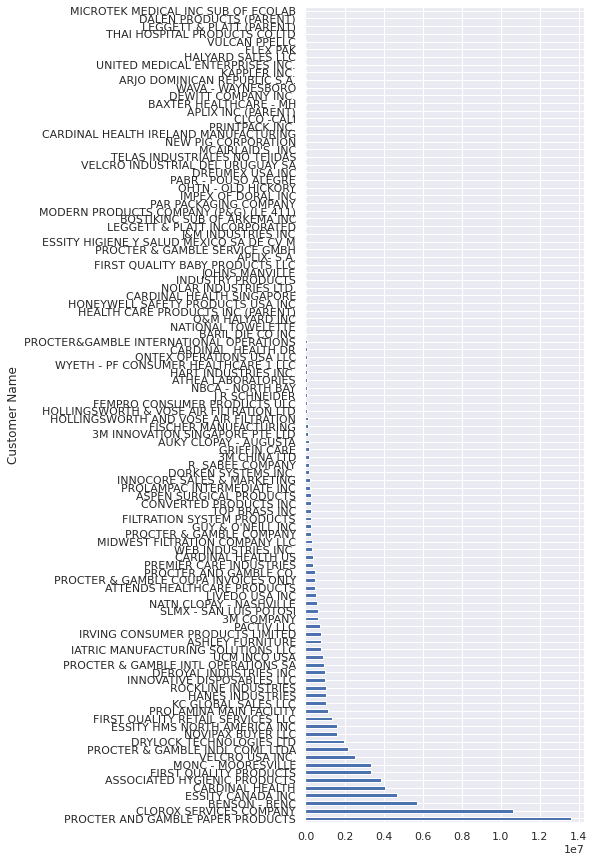

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,15))
df.groupby('Customer Name')[qty].sum().sum(axis=1).sort_values(ascending=False)\
  .plot.barh(ax=ax)

In [ ]:
df.loc[(df[qty] < 0).any(axis=1)]

Level Number  ... User Forecast Array 03 06/2022
968            1.0  ...                   0.000000e+00
274            1.0  ...                   0.000000e+00
275            1.0  ...                   1.550195e+06
515            1.0  ...                   0.000000e+00
617            1.0  ...                   0.000000e+00
917            1.0  ...                   3.962058e+05
1004           1.0  ...                   7.421192e+05

[7 rows x 111 columns]

In [ ]:
df = df.loc[~((df[qty] < 0).any(axis=1))]
df = df.reset_index(drop=True)

<a name='x.1.1'></a>

### 1.1.1 Interactive Monthly

[back to top](#top)

In [ ]:
customers = df.groupby('Customer Name')[qty].sum().sum(axis=1).\
         sort_values(ascending=False).index

def plot_monthly(customer = customers):
  # make df
  dff = df.loc[df['Customer Name'] == customer]
  dff = dff[['Manufacturing Line'] + qty].reset_index(drop=True).set_index('Manufacturing Line').T
  dff = dff.groupby(by=dff.columns, axis=1).sum()

  # make plot data
  data = [go.Bar(x=dff.index,
  y=dff[col],
  name=col) for col in dff.columns]

  # make plot
  fig = go.Figure(data=data)
  fig.update_layout(
    autosize=False,
    width=800,
    height=500)
  return fig

In [ ]:
interact(plot_monthly)

interactive(children=(Dropdown(description='customer', options=('PROCTER AND GAMBLE PAPER PRODUCTS', 'CLOROX S…

<function __main__.plot_monthly>

<a name='x.1.2'></a>

### 1.1.2 Interactive Monthly With Groupby

[back to top](#top)

In [ ]:
customers = df.groupby('Customer Name')[qty].sum().sum(axis=1).\
         sort_values(ascending=False).index

def plot_monthly(customer = customers,
                 groupby = [i for i in desc if 'Customer' not in i]):
  # make df
  dff = df.loc[df['Customer Name'] == customer]
  dff = dff[[groupby] + qty].reset_index(drop=True).set_index(groupby).T
  dff = dff.groupby(by=dff.columns, axis=1).sum()

  # make plot data
  data = [go.Bar(x=dff.index,
  y=dff[col],
  name=col) for col in dff.columns]

  # make plot
  fig = go.Figure(data=data)
  fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title=customer)
  if len(dff.columns) == 1:
    fig.update_layout(title=customer + ', ' + dff.columns[0])
  return fig

In [ ]:
interact(plot_monthly)

interactive(children=(Dropdown(description='customer', options=('PROCTER AND GAMBLE PAPER PRODUCTS', 'CLOROX S…

<function __main__.plot_monthly>

<a name='x.1.3'></a>

### 1.1.3 Descriptive Statistics

[back to top](#top)

In [ ]:
skew = df[qty].skew()
kurt = df[qty].kurtosis()
pd.DataFrame([skew, kurt], index = ['skew', 'kurtosis'])

KG 07/2021  KG 08/2021  KG 09/2021  KG 10/2021  KG 11/2021  \
skew       20.974659   25.518655   25.613421   25.421884   24.903038   
kurtosis  592.018982  812.683383  812.936724  804.389085  781.011708   

          KG 12/2021  KG 01/2022  KG 02/2022  KG 03/2022  KG 04/2022  \
skew       24.821302   11.208232   11.791834   11.558852   14.223440   
kurtosis  777.494405  148.812071  160.795679  154.279191  244.246542   

          KG 05/2022  KG 06/2022  
skew       13.609688   14.654930  
kurtosis  219.156604  253.599467

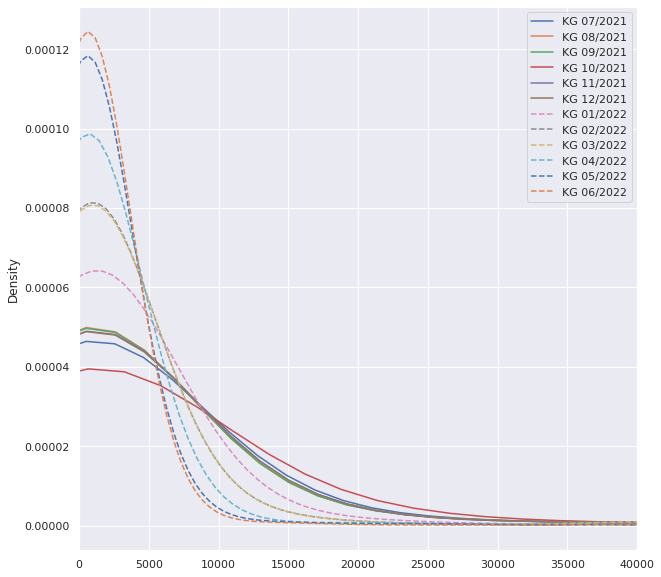

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for ind, col in enumerate(qty):
    if ind > 5:
        df[col].plot.kde(ls='--', ax=ax)
    else:
        df[col].plot.kde(ax=ax)
ax.set_xlim(0,4*1e4)
plt.legend()

<a name='x.2'></a>

## 1.2 Modeling

[back to top](#top)

<a name='x.2.1'></a>

### 1.2.1 Quantity-Only Models

[back to top](#top)

<a name='x.2.1.1'></a>

#### 1.2.1.1 Symbolic Models

[back to top](#top)

With this data, we see a basic trend. Jan, Apr, Jul, Oct are long months while the remaining are short months. We would like to base our predictions on these month-specific averages.

<a name='x.2.1.1.1'></a>

##### 1.2.1.1.1 3 mo. Rule-Based

[back to top](#top)

In [ ]:
# restructure X
# 3 mo. 
# Xxx > next will be X
# xXx > next will be x
# xxX > next will be x

In [ ]:
df.shape

(1578, 111)

In [ ]:
X = []
y = []
for i in range(len(qty)-3):
  X.append(df[qty[i:i+3]].values)
  y.append(df[qty[i+3]].values)
X = np.array(X).reshape(df.shape[0]*np.array(X).shape[0],3)
y = np.array(y).reshape(df.shape[0]*np.array(y).shape[0],)

# drop 0's
X = X[np.where(~np.isnan(y))[0]]
y = y[np.where(~np.isnan(y))[0]]

labels = []
for row in X:
  labels.append("X: {}".format(np.array2string(row.round())))

In [ ]:
X.shape

(14202, 3)

In [ ]:
def sym_model(X):
  y = []
  for row in X:
    if np.argmax(row) == 0:
      y_ = np.max(row)
    else:
      y_ = np.min(row)
    y.append(y_)
  return np.array(y)

In [ ]:
pred = sym_model(X)
r2_score(y, pred)

0.31932991534622956

In [ ]:
fig = px.scatter(x=y, y=pred, hover_name=labels,
                 labels={
                     "y": "Prediction",
                     "x": "Actual"
                 })
fig.update_layout(
  autosize=False,
  width=800,
  height=500,
  title='R2: {:.3f}'.format(r2_score(y, pred))
  )

We can make slight improvements on this model by adjusting when to ignore or return 0s

In [ ]:
def sym_model(X):
  y = []
  for row in X:
    if all((row[1:]) == 0) or all((row.round()) == 0):
      y_ = 0
    elif np.argmax(row) == 0:
      y_ = np.max(row)
    else:
      try:
        y_ = np.min([i for i in row if round(i) > 0])
      except:
        print(row)
        y_ = 0
    y.append(y_)
  return np.array(y)

In [ ]:
pred = sym_model(X)
r2_score(y, pred)

0.40938759237473044

In [ ]:
fig = px.scatter(x=y, y=pred, hover_name=labels,
                 labels={
                     "y": "Prediction",
                     "x": "Actual"
                 })
fig.update_layout(
  autosize=False,
  width=800,
  height=500,
  title='R2: {:.3f}'.format(r2_score(y, pred))
  )

<a name='x.2.1.1.2'></a>

##### 1.2.1.1.2 6 mo. Rule-Based

[back to top](#top)

In [ ]:
def process_data(window=3):
  X = []
  y = []
  for i in range(len(qty)-window):
    X.append(df[qty[i:i+window]].values)
    y.append(df[qty[i+window]].values)
  X = np.array(X).reshape(df.shape[0]*np.array(X).shape[0],window)
  y = np.array(y).reshape(df.shape[0]*np.array(y).shape[0],)
  X = X[np.where(~np.isnan(y))[0]]
  y = y[np.where(~np.isnan(y))[0]]

  labels = []
  for row in X:
    labels.append("X: {}".format(np.array2string(row.round())))
  return X, y, labels

In [ ]:
X, y, labels = process_data(window=6)

In [ ]:
X.shape

(9468, 6)

In [ ]:
def sym_model6(X):
  y = []
  for row in X:
    if all((row[4:]) == 0) or all((row.round()) == 0):
      y_ = 0
    elif np.argmax(row) == 0:
      y_ = np.max(row)
    else:
      y_ = np.min([i for i in row if round(i) > 0])
    y.append(y_)
  return np.array(y)

In [ ]:
pred = sym_model6(X)
r2_score(y, pred)

-0.8023043158858196

In [ ]:
fig = px.scatter(x=y, y=pred, hover_name=labels,
                 labels={
                     "y": "Prediction",
                     "x": "Actual"
                 })
fig.update_layout(
  autosize=False,
  width=800,
  height=500,
  title='R2: {:.3f}'.format(r2_score(y, pred))
  )

<a name='x.2.1.2'></a>

#### 1.2.1.2 Random Forest

[back to top](#top)

Let's deviate from symbolic ai to a machine learning format. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

<a name='x.2.1.2.1'></a>

##### 1.2.1.2.1 3 mo. Forest

[back to top](#top)

In [ ]:
X, y, labels = process_data(window=3)

In [ ]:
clf = RandomForestRegressor(n_estimators=10)
clf.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
pred = clf.predict(X)

In [ ]:
fig = px.scatter(x=y, y=pred, hover_name=labels,
                 labels={
                     "y": "Prediction",
                     "x": "Actual"
                 })
fig.update_layout(
  autosize=False,
  width=800,
  height=500,
  title='R2: {:.3f}'.format(r2_score(y, pred))
  )

<a name='x.2.1.2.2'></a>

##### 1.2.1.2.2 6 mo. Forest

[back to top](#top)

In [ ]:
X, y, labels = process_data(6)

In [ ]:
clf = RandomForestRegressor(n_estimators=10)
clf.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
pred = clf.predict(X)

In [ ]:
fig = px.scatter(x=y, y=pred, hover_name=labels,
                 labels={
                     "y": "Prediction",
                     "x": "Actual"
                 })
fig.update_layout(
  autosize=False,
  width=800,
  height=500,
  title='R2: {:.3f}'.format(r2_score(y, pred))
  )

<a name='x.2.2'></a>

### 1.2.2 Detailed Models

[back to top](#top)

<a name='x.2.2.1'></a>

#### 1.2.2.1 Feature Engineering

[back to top](#top)

we need to turn our categories into numbers. We'll use a method called one-hot encoding.

sklearn has a couple useful libraries for one-hot encoding. let's start with the `OneHotEncoder` class in its `preprocessing` library

In [ ]:
df['Customer Name']

0       HOLLINGSWORTH AND VOSE AIR FILTRATION
1       HOLLINGSWORTH AND VOSE AIR FILTRATION
2                           ESSITY CANADA INC
3       HOLLINGSWORTH AND VOSE AIR FILTRATION
4                                UCM INCO USA
                        ...                  
1573                        ESSITY CANADA INC
1574                        ESSITY CANADA INC
1575                        ESSITY CANADA INC
1576                  PROLAMINA MAIN FACILITY
1577                  PROLAMINA MAIN FACILITY
Name: Customer Name, Length: 1578, dtype: object

In [ ]:
stuff = ['apple', 'orange', 'pear']

# we don't do this
stuff_num = [1, 2, 3]
# pear - orange = apple

# we do this, aka one hot encode
stuff_ortho = [[1,0,0],[0,1,0],[0,0,1]]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# create the encoder object
enc = OneHotEncoder()

# grab the columns we want to convert from strings
X_cat = df["Customer Name"].values.reshape(-1,1)

# fit our encoder to this data
enc.fit(X_cat)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

After fitting our encoder, we can then use this object to create our training array.

In [ ]:
df.shape

(1578, 111)

In [ ]:
# as a reference here's our original data
display(X_cat)
print(X_cat.shape, end='\n\n')

onehotlabels = enc.transform(X_cat).toarray()
print(onehotlabels.shape, end='\n\n')

# And here is our new data
onehotlabels

array([['HOLLINGSWORTH AND VOSE AIR FILTRATION'],
       ['HOLLINGSWORTH AND VOSE AIR FILTRATION'],
       ['ESSITY CANADA INC'],
       ...,
       ['ESSITY CANADA INC'],
       ['PROLAMINA MAIN FACILITY'],
       ['PROLAMINA MAIN FACILITY']], dtype=object)

(1578, 1)

(1578, 106)



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
onehotlabels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [ ]:
# the model needs
# customer name, and prior X months that have been order

# to run by site...
# you would feed the sum of orders for that customer for that site. 

# Hollingsworth
# wava 123 345 456 <-- feed the model this stuff to predict for WAVA
# monc 213 234 543


We are adding 106 "features" into our model. This will prove troublesome, especially if there are many customers who only appear once!

In [ ]:
np.concatenate((onehotlabels, df[qty[i:i+window]].values), axis=1).shape

(1578, 109)

In [ ]:
def process_data(window=3):
  X = []
  y = []
  for i in range(len(qty)-window):
    # I've added a step here in our processing algorithm that includes the
    # one hot encoded vectors
    X.append(np.concatenate((onehotlabels, df[qty[i:i+window]].values), axis=1))
    y.append(df[qty[i+window]].values)

  # and we also need to reshape our array with the new dimensions of the 
  # one hot encoded 
  X = np.array(X).reshape(df.shape[0]*np.array(X).shape[0],window+onehotlabels.shape[1])
  y = np.array(y).reshape(df.shape[0]*np.array(y).shape[0],)
  X = X[np.where(~np.isnan(y))[0]]
  y = y[np.where(~np.isnan(y))[0]]

  # TODO
  # We will need to reverse engineer our onehotlabels to get 
  # the human readable names back. for now just add months
  labels = []
  for row in X:
    labels.append("X: {}".format(np.array2string(row[-3:].round())))
  return X, y, labels

In [ ]:
X, y, labels = process_data(window=3)

In [ ]:
X.shape

(14202, 109)

In [ ]:
X[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

<a name='x.2.2.2'></a>

#### 1.2.2.2 6 mo. Forest with Customer

[back to top](#top)

In [ ]:
clf = RandomForestRegressor(n_estimators=10)
clf.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
pred = clf.predict(X)

In [ ]:
fig = px.scatter(x=y, y=pred, hover_name=labels,
                 labels={
                     "y": "Prediction",
                     "x": "Actual"
                 })
fig.update_layout(
  autosize=False,
  width=800,
  height=500,
  title='R2: {:.3f}'.format(r2_score(y, pred))
  )

<a name='x.3'></a>

## 1.3 Pipeline

[back to top](#top)

In [ ]:
from sklearn.pipeline import make_pipeline

def CustomerForecaster(**kwargs):
    return make_pipeline(RandomForestRegressor(**kwargs))

In [ ]:
CustomerForecaster()

Pipeline(memory=None,
         steps=[('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
              'randomforestregressor__n_estimators': np.arange(5,50,5),
              'randomforestregressor__bootstrap': [True, False]
              }

grid = GridSearchCV(CustomerForecaster(), param_grid, cv=5)

In [ ]:
X = df[qty].values
X = np.concatenate((onehotlabels, df[qty].values), axis=1)
np.random.seed(4)
np.random.shuffle(X)
X_train = X[:int(X.shape[0]*0.8),:]
X_test = X[int(X.shape[0]*0.8):,:]

In [ ]:
X_train.shape

(1262, 118)

In [ ]:
X_test.shape

(316, 118)

In [ ]:
def process_data(X_train, window=3):
  X_cat = X_train[:,:-len(qty)]
  X = X_train[:,-len(qty):]
  X_ = []
  y = []
  for i in range(X.shape[1]-window):
    X_.append(np.concatenate((X_cat, X[:, i:i+window]), axis=1))
    y.append(X[:, i+window])
  X_ = np.array(X_).reshape(X.shape[0]*np.array(X_).shape[0],window+X_cat.shape[1])
  y = np.array(y).reshape(X.shape[0]*np.array(y).shape[0],)
  X_ = X_[np.where(~np.isnan(y))[0]]
  y = y[np.where(~np.isnan(y))[0]]

  labels = []
  for row in X_:
    labels.append("X: {}".format(np.array2string(row[-3:].round())))
  return X_, y, labels

In [ ]:
saved = {}
for window in range(2,12):
  X, y, labels = process_data(X_train, window)
  grid.fit(X, y)
  saved["window: {}".format(window)] = grid.best_params_
  saved["window: {}".format(window)]['best_score'] = grid.best_score_

In [ ]:
pd.DataFrame(saved).T.sort_values('best_score', ascending=False)

randomforestregressor__bootstrap  \
window: 10                             True   
window: 11                            False   
window: 9                              True   
window: 8                             False   
window: 6                              True   
window: 4                              True   
window: 5                              True   
window: 7                              True   
window: 3                              True   
window: 2                              True   

           randomforestregressor__n_estimators best_score  
window: 10                                  25   0.920094  
window: 11                                  10   0.761445  
window: 9                                   15   0.749577  
window: 8                                   35   0.748627  
window: 6                                    5   0.677446  
window: 4                                   15   0.667038  
window: 5                                   25    0.62032  
window: 7                                   35   0.591798  
window: 3                                   10   0.538372  
window: 2                                   25   0.517646

In [ ]:
window = int(pd.DataFrame(saved).T.sort_values('best_score', ascending=False).index[0].split(' ')[1])
window

NameError: ignored

In [ ]:
est = pd.DataFrame(saved).T.sort_values('best_score', ascending=False).iloc[0]['randomforestregressor__n_estimators']
est

NameError: ignored

In [ ]:
window = 10
est = 25

In [ ]:
param_grid = {
              'randomforestregressor__n_estimators': np.arange(max([1,est-5]),est+5,1),
              'randomforestregressor__bootstrap': [True, False]
              }

grid = GridSearchCV(CustomerForecaster(), param_grid, cv=5)
X, y, labels = process_data(X_train, window)
grid.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('randomforestregressor',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                      

In [ ]:
print(grid.best_params_, end='\n\n')
print(grid.best_score_)

{'randomforestregressor__bootstrap': True, 'randomforestregressor__n_estimators': 21}

0.9243285664500982


In [ ]:
X_, y_, labels = process_data(X_test, window=window)
pred = grid.best_estimator_.predict(X_)
fig = px.scatter(x=y_, y=pred, hover_name=labels,
                 labels={
                     "y": "Prediction",
                     "x": "Actual"
                 })
fig.update_layout(
  autosize=False,
  width=800,
  height=500,
  title='R2: {:.3f}'.format(r2_score(y_, pred))
  )

In [ ]:
# customer name, 10 months training data as a sum across the site
# ---> is that prediction acurate 

## Next Steps

The trouble with this approach is that 
* 10 months of data to make a prediction means we are removing a lot of the training data
* and also only predicting those last months out where the forecasts in the training data are truly only forecasts
* consider site/customer

Some additional considerations
* convert onehotlabels to onehot for high frequency customers + everyone else. Recall...

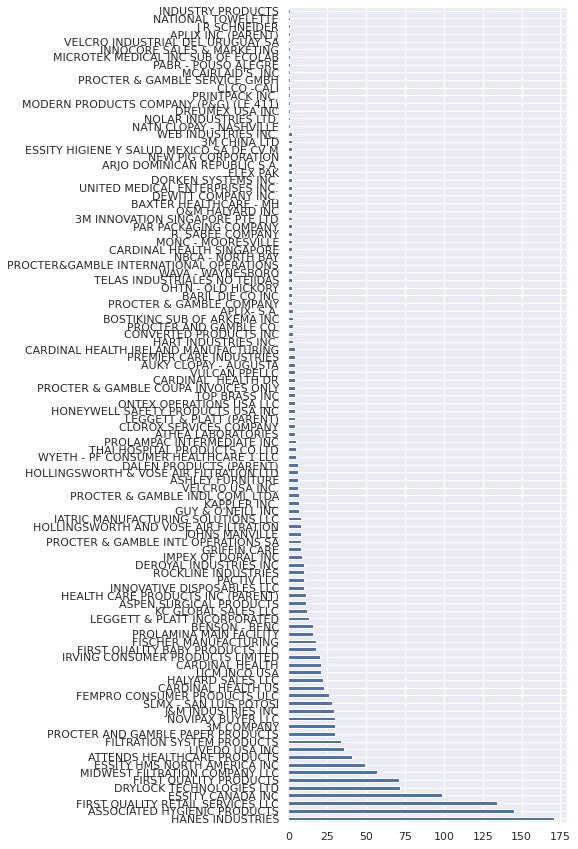

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,15))
df['Customer Name'].value_counts().plot.barh(ax=ax)

In [ ]:
# > predict enxt month based on prior 6
# > predict nect, nect month based prior 5 + last prediction
# > continue ...
# > project out indefinitely

## References

[back to top](#top)

* [Cloud Notebook Options with Microsoft](https://notebooks.azure.com/)